# CNN Based Models

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from input_pipeline import _DATA_DIR_, _BINARIES_DIR_, _UNKNOWN_CLASS_, _SILENCE_CLASS_
from input_pipeline import *
from custom_layers import MFCC, MelSpectrogram
sns.set_context("talk")
# plt.style.use('ggplot')
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2021-08-17 01:29:24.328583: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## Import Data

In [2]:
core_kws, aux_kws, output_classes = get_kws(_DATA_DIR_)
print("Core keywords: ", core_kws)
print()
print("Auxiliary keywords: ", aux_kws)
print()
print("Output Classes: ", output_classes)

Core keywords:  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

Auxiliary keywords:  ['bird', 'seven', 'cat', 'visual', 'three', 'backward', 'zero', 'one', 'six', 'bed', 'two', 'follow', 'dog', 'forward', 'eight', 'house', 'sheila', 'five', 'tree', 'happy', 'marvin', 'nine', 'learn', 'four', 'wow']

Output Classes:  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'filler', 'silence']


In [3]:
# if the binaries for the splits are not yet generated, generate them; otherwise just load them.
if len(os.listdir(_BINARIES_DIR_)) == 0:
    #Get train, validation and test data from the splits provided in the data directory
    X_train, y_train, X_valid, y_valid, X_test, y_test = get_original_splits(_DATA_DIR_)
else:
    X_train, y_train, X_valid, y_valid, X_test, y_test = load_original_splits(_BINARIES_DIR_)

print(f"Samples in Training Set: {len(X_train)}")
print(f"Samples in Test Set: {len(X_test)}")
print(f"Samples in Validation Set: {len(X_valid)}")

Samples in Training Set: 94824
Samples in Test Set: 11005
Samples in Validation Set: 9981


In [4]:
# ADD noise samples to train, valid and test set, with the same proportion of unknown words.
unkn_i = output_classes.index(_UNKNOWN_CLASS_)
sil_i = output_classes.index(_SILENCE_CLASS_)
n_sil_train = len(y_train[y_train==unkn_i])
n_sil_valid = len(y_valid[y_valid==unkn_i])
n_sil_test = len(y_test[y_test==unkn_i])

X_train, y_train, X_valid, y_valid, X_test, y_test = add_silence_samples(X_train, 
                                                                         y_train, 
                                                                         X_valid, 
                                                                         y_valid, 
                                                                         X_test, 
                                                                         y_test,
                                                                        n_sil_train//5,
                                                                        n_sil_valid//5,
                                                                        n_sil_test//5)

In [6]:
train_dataset, train_steps, valid_dataset, valid_steps, test_dataset, test_steps = get_tf_datasets(X_train, 
                             y_train, 
                             X_valid, 
                             y_valid, 
                             X_test, 
                             y_test, 
                             batch_size=128)

data/speech_commands_v0.02/_background_noise_/pink_noise.wav
data/speech_commands_v0.02/_background_noise_/running_tap.wav
data/speech_commands_v0.02/_background_noise_/dude_miaowing.wav
noisy sample
data/speech_commands_v0.02/_background_noise_/dude_miaowing.wav
Train steps: 836
Validations steps: 88
Test steps: 97
Example of dataset element:
(<tf.Tensor: shape=(128, 16000), dtype=float32, numpy=
array([[-1.8996961e-03, -1.9756840e-03, -2.2036475e-03, ...,
        -2.2036475e-03, -2.1276595e-03, -2.2036475e-03],
       [-9.7314129e-05, -2.9194239e-04,  4.8657064e-04, ...,
        -1.7516543e-03, -1.9949398e-03, -1.8003114e-03],
       [-3.5508287e-01, -1.2738426e-01, -7.2634056e-02, ...,
         3.9948728e-02, -1.3867611e-01, -1.8265328e-01],
       ...,
       [ 1.3322114e-03,  2.3839574e-03,  3.3655870e-03, ...,
         3.9265179e-03,  2.8046558e-03,  2.1034917e-03],
       [-3.7411149e-04, -8.7292679e-04, -9.3527872e-04, ...,
        -3.1175956e-04,  1.2470383e-04,  1.1846863e-03

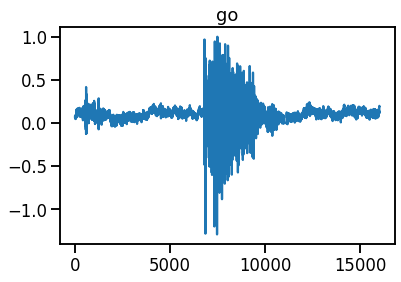

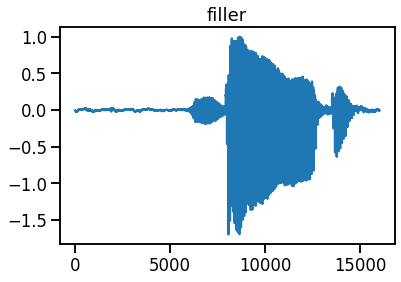

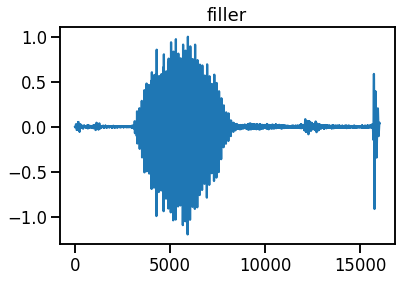

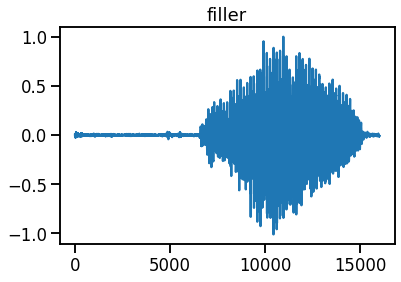

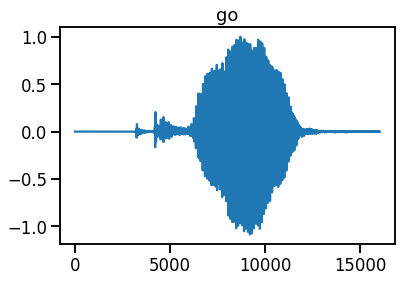

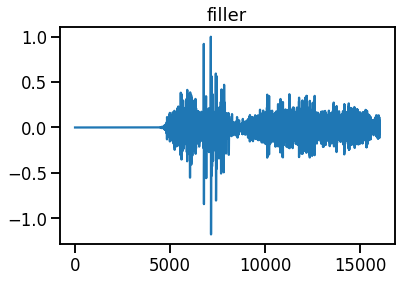

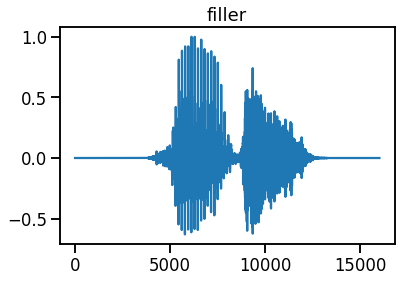

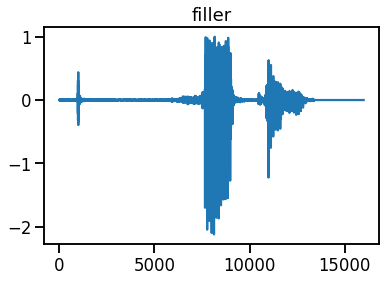

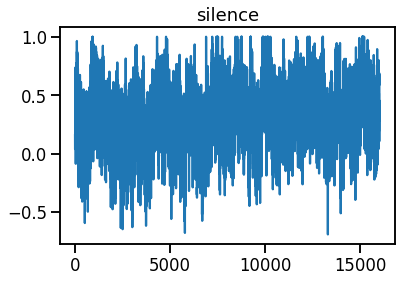

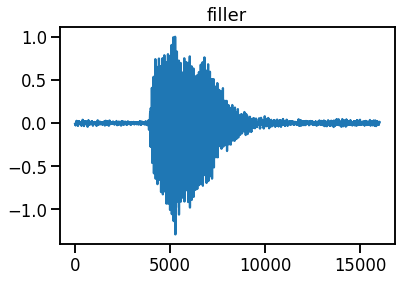

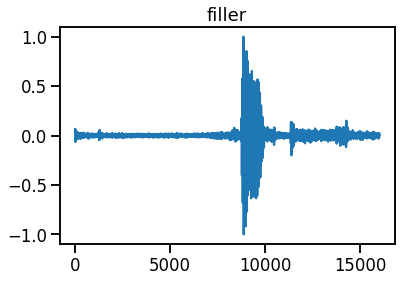

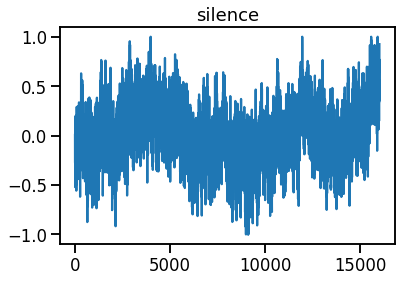

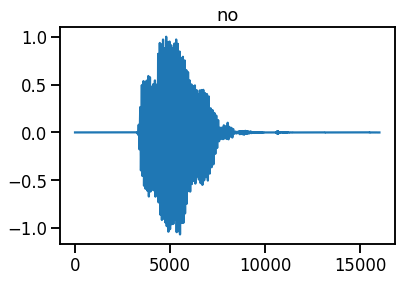

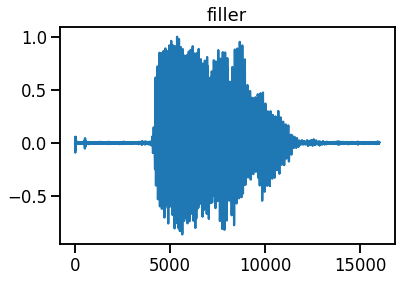

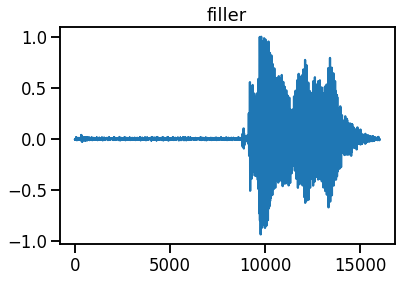

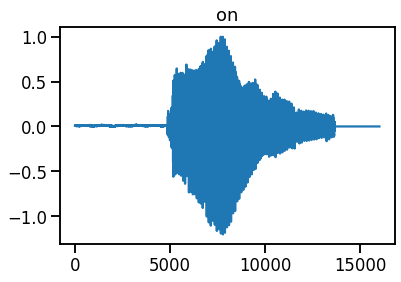

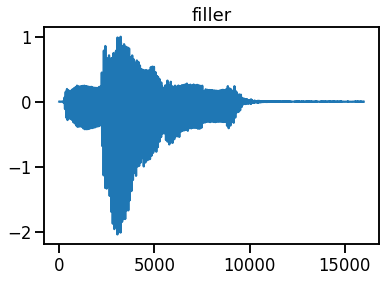

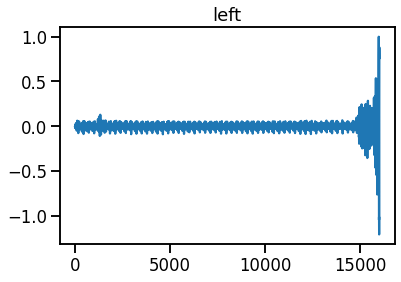

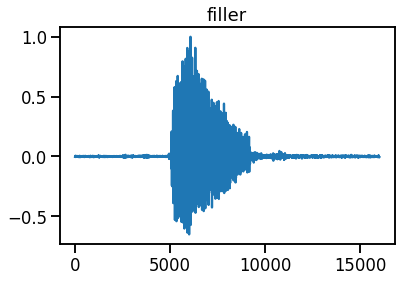

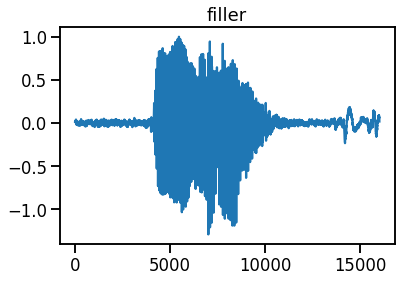

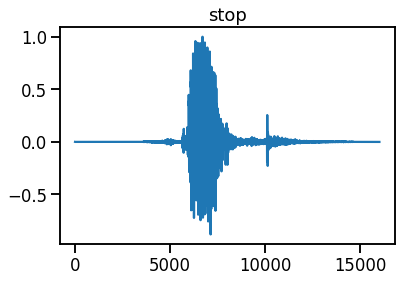

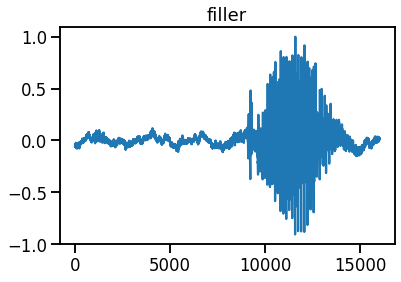

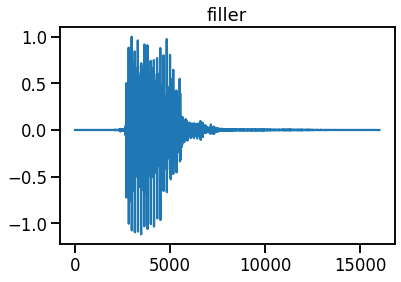

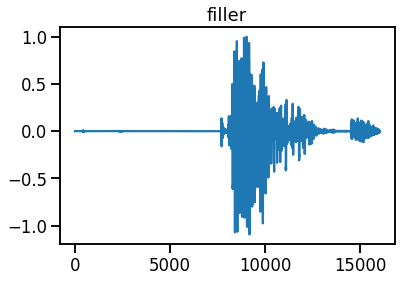

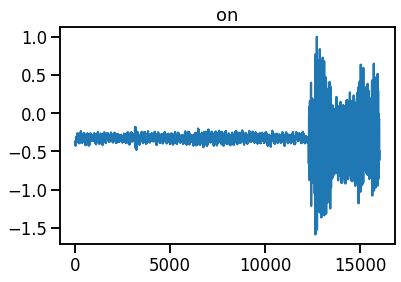

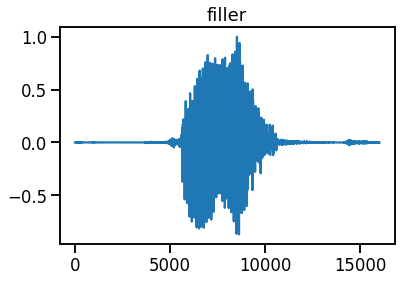

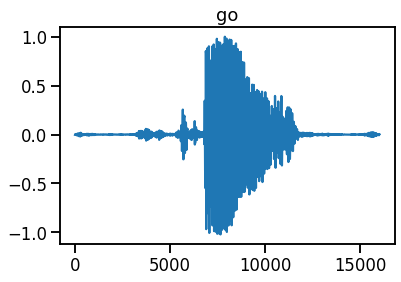

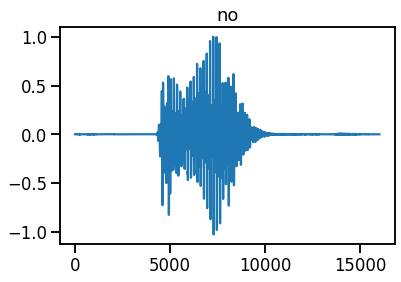

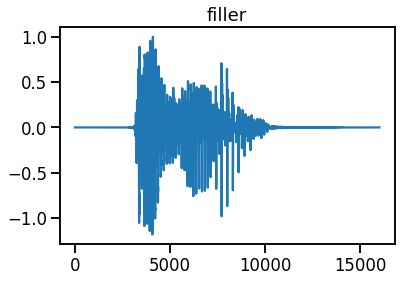

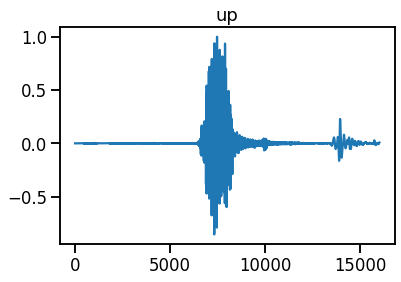

In [7]:
# preview some samples
for sample, label in train_dataset.take(1):
    for i in range(50,80):
        plt.plot(sample[i])
        plt.title(output_classes[label[i]])
        plt.show()
        # We can also preview the sound
        display.display(display.Audio(sample[i], rate=16000))

## Model



In [13]:
def SimpleCNN_2(ds):
    for s, _ in ds.take(1):
        input_shape = s.shape[1:]
        print('Input shape:', input_shape)
    
    X_input = tf.keras.Input(input_shape)
    X = MelSpectrogram(sample_rate = 16000, fft_size=512, win_size=400, hop_size=160, n_filters=40)(X_input)
    X = layers.BatchNormalization(axis=-1)(X)
#     X = MFCC(sample_rate = 16000, fft_size=512, win_size=400, hop_size=160, n_filters=40, n_cepstral=13)(X_input)
#     X = tf.keras.layers.experimental.preprocessing.Resizing(64,64)(X_input)
#     X = norm_layer(X)
    X = layers.Conv2D(54, (X.shape[1],8))(X)
    #pooling in time harmful
#     X = layers.BatchNormalization(axis=-1)(X)
    X = layers.Activation('relu')(X)
#     X = layers.Conv2D(64, 3)(X)
#     X = layers.BatchNormalization(axis=-1)(X)
#     X = layers.Activation('relu')(X)
#     X = layers.Conv2D(16, 5)(X)
#     X = layers.BatchNormalization(axis=-1)(X)
#     X = layers.Activation('relu')(X)
    X = layers.MaxPool2D(pool_size=(1,3))(X)
    X = layers.Flatten()(X)
    X = layers.Dropout(0.25)(X)
    X = layers.Dense(32, activation='relu')(X)
    X = layers.Dense(128, activation='relu')(X)
    X = layers.Dense(128, activation='relu')(X)
    X = layers.Dropout(0.25)(X)
    X = layers.Dense(len(output_classes))(X)
    
    model = tf.keras.Model(inputs = X_input, outputs = X, name='SimpleCNN')
    return model

model2 = SimpleCNN_2(train_dataset)

model2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model2.summary()

Input shape: (16000,)
Model: "SimpleCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16000)]           0         
_________________________________________________________________
mel_spectrogram (MelSpectrog (None, 98, 40, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 40, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 33, 54)         42390     
_________________________________________________________________
activation (Activation)      (None, 1, 33, 54)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 11, 54)         0         
_________________________________________________________________
flatten (Flatten)            (None,

### Class Weights!
Help with class unbalance during training. Source: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=en#class_weights


In [14]:
output_classes

class_weights = {}
for i,cl in enumerate(output_classes):
    amt_i = len(y_train[y_train==i])
#     w_i = (1 / amt_i) * (len(y_train) / 2.0)
    w_i = .1/ (amt_i/len(y_train))
    class_weights[i] = w_i
class_weights

EPOCHS = 50
early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
history = model2.fit(
    train_dataset, 
    validation_data=valid_dataset,  
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps
#     class_weight=class_weights
)



Epoch 1/50


2021-08-17 01:31:17.808361: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2021-08-17 01:31:17.891824: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-17 01:31:18.145196: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-08-17 01:31:18.145693: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-08-17 01:31:18.426503: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100


836/836 [==============================] - 14s 14ms/step - loss: 0.9914 - accuracy: 0.7119 - val_loss: 0.6615 - val_accuracy: 0.7896
Epoch 2/50
836/836 [==============================] - 11s 14ms/step - loss: 0.6833 - accuracy: 0.7827 - val_loss: 0.5377 - val_accuracy: 0.8356
Epoch 3/50
836/836 [==============================] - 12s 14ms/step - loss: 0.5829 - accuracy: 0.8130 - val_loss: 0.4451 - val_accuracy: 0.8620
Epoch 4/50
836/836 [==============================] - 12s 14ms/step - loss: 0.5331 - accuracy: 0.8292 - val_loss: 0.6100 - val_accuracy: 0.8134
Epoch 5/50
836/836 [==============================] - 12s 15ms/step - loss: 0.4985 - accuracy: 0.8403 - val_loss: 0.4237 - val_accuracy: 0.8643
Epoch 6/50
836/836 [==============================] - 12s 15ms/step - loss: 0.4724 - accuracy: 0.8474 - val_loss: 0.5644 - val_accuracy: 0.8414
Epoch 7/50
836/836 [==============================] - 12s 14ms/step - loss: 0.4545 - accuracy: 0.8526 - val_loss: 0.7431 - val_accuracy: 0.8113
Epo

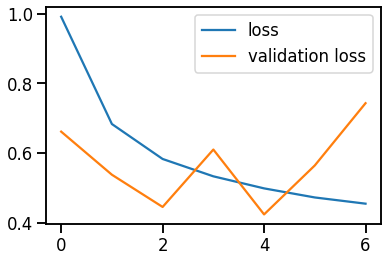

In [15]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'validation loss'])
plt.show()

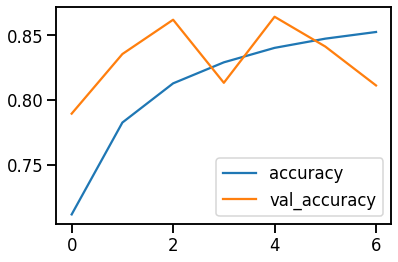

In [16]:
plt.plot(history.epoch,  metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [17]:
y_pred0 = model2.predict(test_dataset, steps=test_steps)[:len(y_test)]
y_pred = np.array(np.argmax(y_pred0, axis=1))
y_true = np.array(y_test)

Test set accuracy: 77.379%


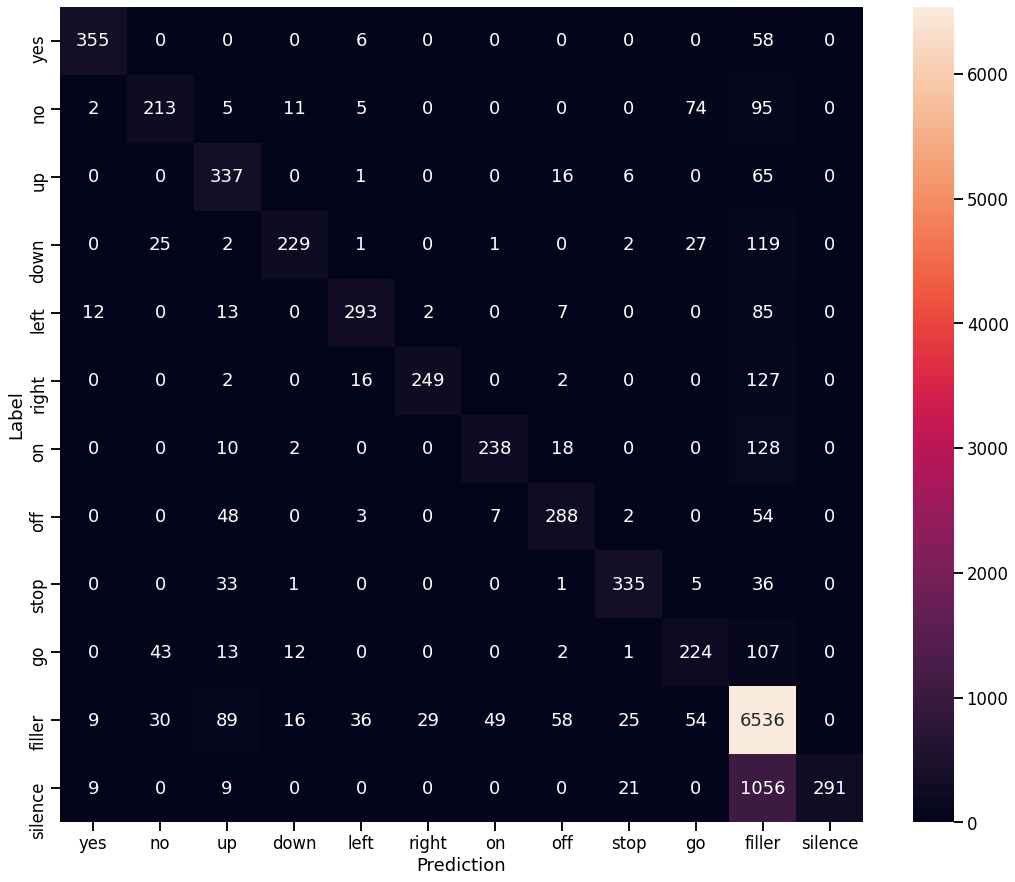

In [18]:
sns.set_context("talk")

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(18, 15))
sns.heatmap(confusion_mtx, xticklabels=output_classes, yticklabels=output_classes, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [21]:
y_pred

array([10,  1, 10, ...,  6, 10, 10])

In [30]:
x = np.zeros(10)
x[[1,5,6]] = 1
x

array([0., 1., 0., 0., 0., 1., 1., 0., 0., 0.])

In [36]:

output_classes.index("silence")

11

In [40]:
def one_class_accuracy(target_class_int, y_pred, y_test):
    class_indexes_pred = np.where(y_pred==target_class_int)
    class_indexes_test = np.where(y_test==target_class_int)

    one_class_pred = np.zeros(len(y_pred))
    one_class_pred[class_indexes_pred] = 1

    one_class_test = np.zeros(len(y_test))
    one_class_test[class_indexes_test] = 1

    test_acc_one_class = sum(one_class_pred == one_class_test) / len(one_class_test)
    return test_acc_one_class


In [43]:
accs = []
for i in range(len(output_classes)):
    print(i, one_class_accuracy(i, y_pred, y_test))
    accs.append(one_class_accuracy(i, y_pred, y_test))

0 0.9922524412880316
1 0.9765959163909289
2 0.9748204341861029
3 0.9823258816883221
4 0.9849084012589783
5 0.9856347348882253
6 0.9826486966346542
7 0.9824065854249052
8 0.9892664030344605
9 0.9727221370349447
10 0.8123638124445162
11 0.9116294084416109


In [45]:
np.mean(accs)

0.9622979043929734

## ROC Curve

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()